# Practica 2

In [1]:
import nltk
import pickle
import numpy as np
from tqdm import tqdm
from unidecode import unidecode
from matplotlib import pyplot as plt
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [2]:
with open('corpusML.txt', 'r') as f:
    corpus = f.readlines()

In [3]:
corpus = [unidecode(line.lower()) for line in corpus]

In [4]:
corpus[0:2]

['comence a trabajar y me pegaron, me maltrataron con chicote \n',
 'mis patrones me pegaron porque no me queria apurar, porque era flojo \n']

### 1, 2) Limpiar corpus y agregar simbolos de inicio y fin

* Se limpia el corpus mediante el algoritmo de Porter para el lenguaje español. 
* A cada oracion del corpus, se le agrega el simbolo de inicio y fin. 
* Se crea el alfabeto $\Sigma$ del corpus donde se almacenen unicamente los tipos 

In [5]:
stemmer = SnowballStemmer("spanish")
stems = []                                              # Lista de stems por cada oracion
cleanedCorpus = []                                      # Corpus procesado con stemming
Sigma = []                                              # Alfabeto del corpus (tipos)               

for sentence in corpus:
    tokens = nltk.word_tokenize(sentence)               # Obtener lista tokens
    for tk in tokens:   
        if tk.isalpha():                                # Validar token como caracter del alfabeto                                
            stem = stemmer.stem(tk)                     # Aplicar algotimo de stemming
            stems.append(stem)                          # Agregarlo a la lista de stems 
            if stem not in Sigma:                       # Agregar stem al alfabeto
                Sigma.append(stem)
    s = '<BOS> ' + ' '.join(stems) + ' <EOS>'           # Agregar simbolos de inicio y fin
    cleanedCorpus.append(s)                             # Agregar oracion procesada a la lista del corpus limpio                               
    stems.clear()

# Agregar simbolos de inicio y fin al alfabeto
Sigma.append('<BOS>')
Sigma.append('<EOS>')

In [6]:
cleanedCorpus[:3]

['<BOS> comenc a trabaj y me peg me maltrat con chicot <EOS>',
 '<BOS> mis patron me peg porqu no me queri apur porqu era floj <EOS>',
 '<BOS> por eso me habi peg <EOS>']

In [7]:
Sigma[-10:]

['cab',
 'bebecit',
 'tabiqu',
 'calent',
 'pajuel',
 'vapor',
 'quemart',
 'cai',
 '<BOS>',
 '<EOS>']

### 3) Obtener los bigramas

In [8]:
# Funcion para obtener los bigramas de una secuencia de caracteres
def bigrams(sequence):
    s = sequence.split()
    return [(wi, wj) for wi, wj in zip(s[:-1], s[1:])]

In [9]:
# Obtener los bigramas del corpus limpio
sentence_bigrams = [bigrams(s) for s in cleanedCorpus]

In [10]:
# Bigramas de la primera oracion
sentence_bigrams[0]

[('<BOS>', 'comenc'),
 ('comenc', 'a'),
 ('a', 'trabaj'),
 ('trabaj', 'y'),
 ('y', 'me'),
 ('me', 'peg'),
 ('peg', 'me'),
 ('me', 'maltrat'),
 ('maltrat', 'con'),
 ('con', 'chicot'),
 ('chicot', '<EOS>')]

In [11]:
# Bigramas de todo el corpus
corpus_bigrams = [bigram for sentence in sentence_bigrams for bigram in sentence]

In [12]:
corpus_bigrams[0:11]

[('<BOS>', 'comenc'),
 ('comenc', 'a'),
 ('a', 'trabaj'),
 ('trabaj', 'y'),
 ('y', 'me'),
 ('me', 'peg'),
 ('peg', 'me'),
 ('me', 'maltrat'),
 ('maltrat', 'con'),
 ('con', 'chicot'),
 ('chicot', '<EOS>')]

In [13]:
# Obtener los vectores one hot de cada palabra en el corpus
oneHotMatrix = np.identity(len(Sigma))

In [14]:
word2oneHot = {}        # Entrada: palabra del alfabeto, Salida: vector one hot
word2number = {}        # Entrada: palabra del alfabeto, Salida: indice en la lista del alfabeto
oneHot2word = {}        # Entrada: vector one hot (caracteres), Salida: palabra del alfabeto

for i, (word, vector) in enumerate(zip(Sigma, oneHotMatrix)):
    word2oneHot[word] = vector
    word2number[word] = i
    oneHot2word[np.where(vector==1)[0][0]] = word

In [15]:
word2oneHot['<EOS>']

array([0., 0., 0., ..., 0., 0., 1.])

In [16]:
word2number['<EOS>']

1215

### 4) Entrenar la red neuronal con los bigramas

Dados los bigramas del corpus $(w_i, w_j)$, la red neuronal word2vec es entrenada tomando como entrada y salida a la representacion vectorial *one hot encoded* de la palabra $w_i$ y la palabra $w_j$ respectivamente.

Los vectores de entrada tienen una dimension $x\in\mathbb{R}^{|\Sigma|}$ , que es el tamaño del alfabeto que obtuvimos a partir de los tipos del corpus.

En cuanto a la dimension de la primera capa (embedding), sera de 300 unidades neuronales por lo que la matriz de pesos tiene una dimension $U\in\mathbb{R}^{300x|\Sigma|}$.

Las dimensiones de la matriz de pesos de la segunda capa son de $W\in\mathbb{R}^{|\Sigma|x300}$.

#### Feed forward

**Capa 1**

La salida de la i-ésima neurona de la primera capa se calcula como: 

$h_i = \sum_{j=1}^{N}U_{ij}x_j$

Tambien se puede expresar de forma más general como el producto punto:

$h = U \cdot x$

$h = U_{\cdot,i}$

Este vector tiene una dimension $h\in\mathbb{R}^{300}$, por lo que realizar el producto punto entre la matriz de pesos $U$ y el vector one hot encoded $x$ que representa a la palabra $w_i$ es equivalente a seleccionar la columna i-ésima de $U$. 

**Capa 2**

La salida de la segunda capa se calcula como:

$a = W\cdot{h}$ 

$a = W_{i,\cdot}$

y tiene una dimension de $a\in\mathbb{R}^{|\Sigma|}$, lo cual es equivalente a seleccionar la fila i-ésima de la matriz $W$.

**Salida**

La funcion de activacion a la salida de esta ultima capa es la funcion *softmax* en la cual se calcula la probabilidad de que la palabra $w_k$ donde $k=1,...,|\Sigma|$ , aparesca despues de la palabra de entrada $w_i$, lo cual se expresa como:

$p(w_k|w_i) = \frac{e^{W\cdot{h}}}{\sum_{m}^{|\Sigma|}e^{W\cdot{h}}}$

In [17]:
d = 300                                  # Dimension del embedding
N = len(Sigma)                           # Tamaño del alfabeto

In [18]:
def softmax(x):
    exp = np.exp(x-np.max(x))
    return np.divide(exp, np.sum(exp))

In [19]:
def predict(x):
    h = np.dot(U, x)
    a = np.dot(W, h)
    return softmax(a)

In [65]:
def fit(bigrams, lr, epochs):
    global U, W
    lossWi = []
    loss = []
    for epoch in range(epochs):
        for k, (wi, wj) in enumerate(bigrams):
            x = word2oneHot[wi]
            y = word2oneHot[wj]
            # Feedforward
            #h = np.dot(U, x)
            h = U[:, np.where(x==1)[0][0]]
            a = np.dot(W, h)
            # Calcular error
            error = softmax(a) - y
            # ---- Calcular funcion de perdida ----
            lossWi.append(np.sum(y*np.log(softmax(a)+0.001)))
            if k == len(bigrams)-1:
                loss.append(-np.sum(lossWi))
                lossWi.clear()
                print('EPOCH ({}) = {}'.format(epoch+1, loss[epoch]))
            # -------------------------------------
            # Backpropragation
            #W[np.where(y==1)[0][0],:] -= lr*error[np.where(y==1)[0][0]]*h
            W -= lr*np.dot(error.reshape(-1,1), h.reshape(1,-1))
            delta = np.dot(W.T, error)
            U[:,np.where(x==1)[0][0]] -= lr*delta
            #U -= lr*np.dot(delta.reshape(-1,1), x.reshape(1,-1))
    return loss

In [29]:
U = np.random.randn(d, N)    # Matriz de embedding 
W = np.random.randn(N, d)    # Matriz de pesos capa 2

In [30]:
err = fit(corpus_bigrams, 0.0005, 1000)

EPOCH (1) = 85633.23816496578
EPOCH (2) = 83750.72831874664
EPOCH (3) = 81030.97279660465
EPOCH (4) = 79311.6536918427
EPOCH (5) = 77653.52316318652
EPOCH (6) = 76601.43861457607
EPOCH (7) = 75525.73350375805
EPOCH (8) = 74584.38417718069
EPOCH (9) = 73733.74207199956
EPOCH (10) = 72865.39068819575
EPOCH (11) = 71847.33640213052
EPOCH (12) = 71087.68197332288
EPOCH (13) = 70449.14098774218
EPOCH (14) = 69777.67695717557
EPOCH (15) = 69065.90771486607
EPOCH (16) = 68444.3452426522
EPOCH (17) = 67903.3565909153
EPOCH (18) = 67330.6623950181
EPOCH (19) = 66727.65057591711
EPOCH (20) = 66168.05001799975
EPOCH (21) = 65630.44428927547
EPOCH (22) = 65109.1693794273
EPOCH (23) = 64605.47055661385
EPOCH (24) = 64112.19198782244
EPOCH (25) = 63629.01567257372
EPOCH (26) = 63148.22639329176
EPOCH (27) = 62691.82024819446
EPOCH (28) = 62272.78653271911
EPOCH (29) = 61881.71093763544
EPOCH (30) = 61511.97142219711
EPOCH (31) = 61160.610431556765
EPOCH (32) = 60830.16147619237
EPOCH (33) = 60507.79

EPOCH (260) = 36586.85714675677
EPOCH (261) = 36578.5228984931
EPOCH (262) = 36570.493940425964
EPOCH (263) = 36562.762691698495
EPOCH (264) = 36555.323162963636
EPOCH (265) = 36548.16922726491
EPOCH (266) = 36541.293064517675
EPOCH (267) = 36534.68433048234
EPOCH (268) = 36528.330178546545
EPOCH (269) = 36522.21588995295
EPOCH (270) = 36516.32574786067
EPOCH (271) = 36510.643905916935
EPOCH (272) = 36505.15517964262
EPOCH (273) = 36499.84577839352
EPOCH (274) = 36494.70397399632
EPOCH (275) = 36489.720636042795
EPOCH (276) = 36484.88952023513
EPOCH (277) = 36480.207200746125
EPOCH (278) = 36475.67258876151
EPOCH (279) = 36471.28607145133
EPOCH (280) = 36467.0484248534
EPOCH (281) = 36462.95975613502
EPOCH (282) = 36459.018744294706
EPOCH (283) = 36455.22233510349
EPOCH (284) = 36451.565859918475
EPOCH (285) = 36448.04340600783
EPOCH (286) = 36444.6482462502
EPOCH (287) = 36441.37321744611
EPOCH (288) = 36438.21103474023
EPOCH (289) = 36435.154573898704
EPOCH (290) = 36432.19713289845


EPOCH (515) = 36287.393916905145
EPOCH (516) = 36287.2260409756
EPOCH (517) = 36287.05913250506
EPOCH (518) = 36286.89318233753
EPOCH (519) = 36286.728181433704
EPOCH (520) = 36286.56412086916
EPOCH (521) = 36286.40099183238
EPOCH (522) = 36286.23878562305
EPOCH (523) = 36286.07749365027
EPOCH (524) = 36285.91710743075
EPOCH (525) = 36285.757618587195
EPOCH (526) = 36285.59901884655
EPOCH (527) = 36285.44130003841
EPOCH (528) = 36285.28445409339
EPOCH (529) = 36285.128473041565
EPOCH (530) = 36284.973349010885
EPOCH (531) = 36284.8190742257
EPOCH (532) = 36284.66564100522
EPOCH (533) = 36284.513041762104
EPOCH (534) = 36284.36126900099
EPOCH (535) = 36284.2103153171
EPOCH (536) = 36284.06017339482
EPOCH (537) = 36283.91083600643
EPOCH (538) = 36283.76229601068
EPOCH (539) = 36283.61454635153
EPOCH (540) = 36283.46758005684
EPOCH (541) = 36283.321390237164
EPOCH (542) = 36283.17597008444
EPOCH (543) = 36283.031312870844
EPOCH (544) = 36282.88741194756
EPOCH (545) = 36282.74426074358
EPO

EPOCH (770) = 36262.028145329416
EPOCH (771) = 36261.96695812768
EPOCH (772) = 36261.905936682524
EPOCH (773) = 36261.84508013661
EPOCH (774) = 36261.784387638574
EPOCH (775) = 36261.723858342906
EPOCH (776) = 36261.66349140998
EPOCH (777) = 36261.60328600597
EPOCH (778) = 36261.54324130276
EPOCH (779) = 36261.483356477984
EPOCH (780) = 36261.42363071489
EPOCH (781) = 36261.36406320234
EPOCH (782) = 36261.30465313475
EPOCH (783) = 36261.24539971202
EPOCH (784) = 36261.18630213955
EPOCH (785) = 36261.12735962811
EPOCH (786) = 36261.068571393866
EPOCH (787) = 36261.00993665829
EPOCH (788) = 36260.95145464814
EPOCH (789) = 36260.89312459537
EPOCH (790) = 36260.83494573717
EPOCH (791) = 36260.77691731586
EPOCH (792) = 36260.71903857883
EPOCH (793) = 36260.66130877854
EPOCH (794) = 36260.60372717248
EPOCH (795) = 36260.54629302309
EPOCH (796) = 36260.489005597774
EPOCH (797) = 36260.43186416877
EPOCH (798) = 36260.37486801321
EPOCH (799) = 36260.318016413046
EPOCH (800) = 36260.26130865494


In [35]:
# Guardar parametros de la red
with open('weights.pickle', 'wb') as file:
    pickle.dump([U, W, err], file)

In [70]:
# Leer el archivo con los parametros
# y verificar que sean correctos
with open('weights.pickle', 'rb') as file:
    U, W, err = pickle.load(file)

In [72]:
#err2 = fit(corpus_bigrams, 0.0009, 1000)

In [48]:
# Prueba de prediccion
word = 'las'
wordVector = word2oneHot[stemmer.stem(word)]
pred = predict(wordVector)
print('Suma = ', np.sum(pred))                    # Suma para verificar que sea igual a 1
indice = np.argmax(pred)                          # Indice de la palabra con mayor probilidad
word_predicted = oneHot2word[indice] 

print('Indice palabra pred = ', indice)
print('Prediccion = ', word_predicted)
print('P({}|{}) = {}'.format(word_predicted, word, pred[indice]))
print(word + ' ' + word_predicted)

Suma =  1.0
Indice palabra pred =  290
Prediccion =  vac
P(vac|las) = 0.09893835625511695
las vac


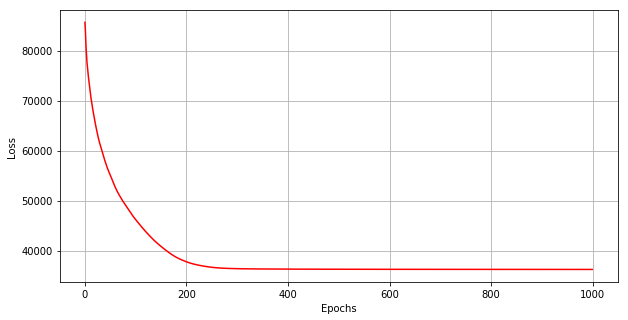

In [34]:
plt.figure(figsize=(10,5))
plt.title('')
plt.plot(err, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

### 5) Obtener las matrices $A$ y $\Pi$

In [278]:
# Para cada palabra del alfabeto, predecir el vector de probabilidades
# y agruparlos por columna para hacer la matriz A

# A = []

# for wj in Sigma[:-2]:
#     aj = predict(word2oneHot[wj])
#     A.append(list(aj))
    
# A = np.matrix(A).T

In [280]:
# El vector de inicio se obtiene al predecir la distribucion
# para el simbolo <BOS>
# Pi = predict(word2oneHot['<BOS>'])

### 6) Calcular la propabilidad de las siguientes oraciones

Se calcularan usando la propiedad de Markov que establece que:

$p(x_1,...,x_n)=\prod_{i=1}^{n}p(w_{i}|w_{i-1})$

1) Nos ba;amos con agua caliente

$p(caliente|agua)p(agua|con)p(con|banamos)p(banamos|nos)p(nos|bos)$

In [299]:
#s = 'Nos banamos con agua caliente'.split()
# s = '<BOS> pascuala ordenaba las vacas'.split()
# s[1:] = [stemmer.stem(word.lower()) for word in s[1:]]

In [300]:
#j = word2number['las']
#i = word2number['vacas']

#A[i,j]

In [301]:
#Pi[word2number['pues']]

In [302]:
# p = 1

# for wi, wj in zip(s[:-1], s[1:]):
#     if wi == '<BOS>':
#         p *= Pi[word2number[wj]]
#     else:
#         i = word2number[wj]
#         j = word2number[wi]
#         p *= A[i,j]
        
# print('p(s) = ', p)

p(s) =  2.425589910422211e-19
